# Functions and import

In [ ]:
pip install FlowCytometryTools

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from FlowCytometryTools import FCMeasurement
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [ ]:
def summorize_fcs(meta, data_path):
    '''
    Function that writes medians of each channel into a file
    :param meta: pandas dataframe with metadata with the following columns: 
        file_name, sample_id, condition, patient_id. See example of the metadata table below
    
    :param data_path: path to .fsc files
    
    ** Windows Users **
 
    Windows uses the backslash character (‘\’) for paths. However, the backslash character
    is a special character in python that is used for formatting strings. 
    In order to specify paths correctly, you must precede the path with the character ‘r’.
 
    Good:
 
    >>> data_path=r'C:\data\'
    Bad:
 
    >>> data_path='C:\data\'
    
    
    :returns: 1) dataframe markers by samples
    2) dictionary with markers as keys and a median values for healthy and patients
    
    '''
    
    files = list(meta.file_name)
    status = list(meta.condition)
    samp = list(meta.sample_id)
    #open the first file to retrieve the order of markers
    sample = FCMeasurement(ID='Sample', datafile=data_path +files[0])
    dat1 = sample.data
    genes = dat1.columns
    genes = [x.split("_")[0] for x in genes]
 
    # matrix with medians for each marker and each sample
    medians_full = np.zeros((len(genes), len(samp)))
    # dictionary with medians for each sample and each condition
    medians_cond = dict()
 
    # file processing is performed per marker to avoid loading too much data into memory
    for i in range(len(genes)):
        gene = genes[i]
        old = 0
        for j in range(len(files)):
            st = status[j]
            file = files[j]
            gr = samp[j]
            sample = FCMeasurement(ID='Sample', datafile=data_path +file)
            dat1 = sample.data
            gs = dat1.columns
            genes_new = [x.split("_")[0] for x in gs]
            dat1.columns = genes_new
            new_dat = dat1[[gene]]
            new_dat.columns = ["expression"]
            new_dat["group"] = [gr]*dat1.shape[0]
            new_dat["antibody"] = [gene]*dat1.shape[0]
            new_dat["status"] = [st]*dat1.shape[0]
            new_dat.index = np.arange(old,dat1.shape[0]+old)
            old = dat1.shape[0] + old
            if j == 0:
                all_dat = new_dat.copy()
            else:    
                all_dat = pd.concat([all_dat, new_dat])
        #data transformation
        all_dat.expression = np.arcsinh(all_dat.expression/5)    
        #medians for healthy and patients
        hp = all_dat['expression'][all_dat['status'] == 'healthy']
        cp = all_dat['expression'][all_dat['status'] == 'patient']
        medians_cond[gene] = [np.median(hp), np.median(cp)]
        #medians for each sample
        for j in range(len(samp)):
            s = samp[j]
            condition = (all_dat['group'] == s) 
            vals = all_dat['expression'][condition]
            medians_full[i,j] = np.median(vals)
    medians_full = pd.DataFrame(medians_full, index = genes, columns = samp)
    return(medians_full, medians_cond)
 
 
def pv_estimate(dat, markers, model):
    '''
    Computes p-values based on LMM and then performs FDR correction
    :param dat: pandas dataframe
    :param markers: a list of markers to test
    :param model: a string with model description
    '''
    pvs = []
    for m in markers:
        d = dat[dat.marker == m]
        md = smf.mixedlm(model,d ,
                     groups=d["samples"])
        try:
            mdf = md.fit()
 
            pvs.append((m,mdf.pvalues[1]))
        except np.linalg.LinAlgError:
            pvs.append((m,np.nan))
    # for correction we save only those p-values that were actually computed and did not crash due to 0 variance
    ms = []
    ps = []
    for g,p in pvs:
        if not np.isnan(p):
            ps.append(p)
            ms.append(g)
    #FDR correction
    _, new_pv = sm.stats.fdrcorrection(ps, alpha=0.05, method='indep', is_sorted=False)
    result = dict()
    for i in range(len(new_pv)):
        result[ms[i]] = new_pv[i]
    return(result)

# Reading and summorizing data

## Not activated data

In [ ]:
meta_na = pd.read_excel("/content/meta_na.xlsx" , sheet_name="Tabelle1")
display(meta_na)

In [ ]:
# create folder named: files_na
files = "/content/files_na/"

medians_full_na, medians_cond_na = summorize_fcs(meta_na, files)


In [ ]:
medians_full_na.head()

In [ ]:
medians_full_na

## Activated samples

In [ ]:
meta_act = pd.read_excel("/content/meta_act.xlsx", sheet_name="Sheet1")
display(meta_act)

In [ ]:
files = "/content/files_a/"
medians_full_act, medians_cond_act = summorize_fcs(meta_act, files)

In [ ]:
medians_full_act.head()

In [ ]:
medians_full_act

## Concatinating both datasets together for further analysis


In [ ]:
meta = pd.concat([meta_na,meta_act], ignore_index=True)
markers = medians_full_na.index
samples = medians_full_na.columns
conditions = [list(meta_na.condition[meta_na.sample_id == x])[0] for x in samples]

last_i = 0
for i in range(len(markers)):
    m = markers[i]
    dat1 = medians_full_na.loc[[m]].T
    dat1.columns = ["expression"]
    dat1["samples"] = dat1.index
    dat1.index= np.arange(last_i,dat1.shape[0]+last_i)
    last_i = dat1.shape[0] +last_i
    dat1["marker"] = [m]*dat1.shape[0]
    dat1["condition"] = conditions
    dat1["type"] = ["not activated"]*dat1.shape[0]
    if i == 0:
        dat = dat1
    else:
        dat = pd.concat([dat,dat1])

markers = medians_full_act.index
samples = medians_full_act.columns
conditions = [list(meta_act.condition[meta_act.sample_id == x])[0] for x in samples]        
for i in range(len(markers)):
    m = markers[i]
    dat1 = medians_full_act.loc[[m]].T
    dat1.columns = ["expression"]
    dat1["samples"] = dat1.index
    dat1.index= np.arange(last_i,dat1.shape[0]+last_i)
    last_i = dat1.shape[0] +last_i
    dat1["marker"] = [m]*dat1.shape[0]
    dat1["condition"] = conditions
    dat1["type"] = ["activated"]*dat1.shape[0]

    dat = pd.concat([dat,dat1])

# Activation slope ananlysis

## Set activation marker and plot dimensions

In [ ]:
# Marker definition
dat["patient"] = [x[:-1] for x in dat["samples"]]
ylims = {"CD63": (0,0.5), "CD107a": (-0.5,0.5), "PAC1": (0, 2), "CD62P": (0, 2), "CD154": (-0.5,0.5)}

act_m = ["155Gd", "150Nd", "151Eu", "161Dy", "168Er"]

panel = list(set(markers).difference(set(act_m)))

## Slope plotting

In [ ]:
datMP = dat

warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(14, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)
datTB = datMP

patients = list(set(datTB))
colors = ['#9AB8C8', '#DBA794']

for i in range(len(act_m)):
    ax = fig.add_subplot(3, 5, i+1)
    m= act_m[i]
    d1 = list(datTB[(datTB.marker == m)&(datTB.condition == "baseline")]["expression"])
    d2 = list(datTB[(datTB.marker == m)&(datTB.condition == "stimulated")]["expression"])
    display(d1)
    display(d2)
  #plot scatter for each marker
    s1 = ax.scatter(np.ones(len(d1)),d1, c = "#c89ab8", alpha = 0.8)
    s2 = ax.scatter(np.ones(len(d1))*2,d2, c = "#c89ab8", alpha = 0.8)

 # compute the slope
    d = datTB[(datTB.marker == m) ]
    #display(d)
    md = smf.mixedlm("expression ~ type",d, groups=d["condition"]) 
    mdf = md.fit()
  
  # print the slope in the plot title
    ax.set_title("{0}: slope {1}".format(m, np.round(np.abs(list(mdf.params)[1]),2))) 
    display(mdf.params)
  # make y lable for the most left plot
    if i == 0:
        ax.set_ylabel('Median expression')
  
  # for each pair of patients plot a line from not activated sample to activated
    for p in patients:
      p1 = list(datTB[(datTB.marker == m)&(datTB.condition == "baseline")]["expression"])[0]
      p2 = list(datTB[(datTB.marker == m)&(datTB.condition == "stimulated")]["expression"])[0]
      plt.plot([1,2],[p1,p2], c = "black", linestyle = "--", alpha = 0.3)
    
   

    # plot the regression fit
    plt.sca(ax)
    plt.xticks([1,2], [' ', ' '])
    xs = [1,0]
    b0 = mdf.params[0]
    b1 = mdf.params[1]
    ys = [b0 + b1*x for x in xs]
    #ys = [0,0.8]  # use for scale changes
    plt.plot(np.array(ax.get_xlim()),ys, c = '#c89ab8', linestyle = "-", alpha = 0.8, linewidth=7) #9AB8C8 old color
    plt.xticks([1,2], ['baseline', 'stimulated'])
    try:
      plt.ylim(ylims[m])
    except:
      KeyError

Manual data

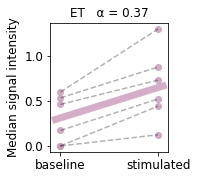

In [ ]:
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(14, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)
colors = ['#9AB8C8', '#DBA794']
act_m = ["1"]

for i in range(len(act_m)):
    ax = fig.add_subplot(3, 5, i+1)
    m= act_m[i]
     
    d1 = [0.598107457160949,0.532804727554321,0.171692371368408,0,0.46054595708847,0]
    d2 = [1.29868900775909,0.875978469848632,0.521425724029541,0.124212078750133,0.731105923652648,0.441995769739151]
    d3 = d1+d2
    dtype = ["not activated","not activated","not activated","not activated","not activated","not activated","activated","activated","activated","activated","activated","activated"]
    dcond = ["baseline","baseline","baseline","baseline","baseline","baseline","stimulated","stimulated","stimulated","stimulated","stimulated","stimulated"]

    data = pd.DataFrame(
      {'expression': d3,
      'type': dtype,
       'condition' : dcond
      })


  #plot scatter for each marker
    s1 = ax.scatter(np.ones(len(d1)),d1, c = "#c89ab8", alpha = 0.8) #9AB8C8 old color c89ab8
    s2 = ax.scatter(np.ones(len(d1))*2,d2, c = "#c89ab8", alpha = 0.8) #9AB8C8 old color c89ab8

 # compute the slope
    d = data
    #display(d)
    md = smf.mixedlm("expression ~ type",d, groups=d["condition"]) 
    mdf = md.fit()
    ###print(mdf.summary())
  
  # print the slope in the plot title
    ax.set_title("ET   α = {1}".format(m, np.round(np.abs(list(mdf.params)[1]),2))) ########## Change name here
    #display(mdf.params)
  # make y lable for the most left plot
    if i == 0:
        ax.set_ylabel('Median signal intensity')
  
  # for each pair of patients plot a line from not activated sample to activated 
    for f, b in zip(d1, d2):
      plt.plot([1,2],[f,b], c = "black", linestyle = "--", alpha = 0.3)
    



    # plot the regression fit
    plt.sca(ax)
    plt.xticks([1,2], [' ', ' '])
    xs = [1,0]
    b0 = mdf.params[0]
    b1 = mdf.params[1]
    ys = [b0 + b1*x for x in xs]
    #ys = [0,0.8]  # use for scale changes
    plt.plot(np.array(ax.get_xlim()),ys, c = '#c89ab8', linestyle = "-", alpha = 0.8, linewidth=7) #9AB8C8 old color c89ab8
    plt.xticks([1,2], ['baseline', 'stimulated'])
    try:
      plt.ylim(ylims[m])
    except:
      KeyError
      
plt.savefig("/content/activation_ET_CD63.pdf",dpi = 1000)
#datTB.to_csv("/content/all_values_healthy.csv", index = False, header=True)

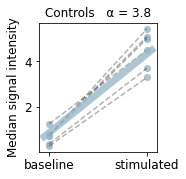

In [ ]:
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(14, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)
colors = ['#9AB8C8', '#DBA794']
act_m = ["1"]

for i in range(len(act_m)):
    ax = fig.add_subplot(3, 5, i+1)
    m= act_m[i]
     
    d1 = [1.26,0.8,0.735,0.745,0.385,0.295]
    d2 = [4.5,5.09,5,5.43,3.7,3.3]
    d3 = d1+d2
    dtype = ["not activated","not activated","not activated","not activated","not activated","not activated","activated","activated","activated","activated","activated","activated"]
    dcond = ["baseline","baseline","baseline","baseline","baseline","baseline","stimulated","stimulated","stimulated","stimulated","stimulated","stimulated"]

    data = pd.DataFrame(
      {'expression': d3,
      'type': dtype,
       'condition' : dcond
      })


  #plot scatter for each marker
    s1 = ax.scatter(np.ones(len(d1)),d1, c = "#9AB8C8", alpha = 0.8) #9AB8C8 old color c89ab8
    s2 = ax.scatter(np.ones(len(d1))*2,d2, c = "#9AB8C8", alpha = 0.8) #9AB8C8 old color c89ab8

 # compute the slope
    d = data
    #display(d)
    md = smf.mixedlm("expression ~ type",d, groups=d["condition"]) 
    mdf = md.fit()
    ###print(mdf.summary())
  
  # print the slope in the plot title
    ax.set_title("Controls   α = {1}".format(m, np.round(np.abs(list(mdf.params)[1]),2))) ########## Change name here
    #display(mdf.params)
  # make y lable for the most left plot
    if i == 0:
        ax.set_ylabel('Median signal intensity')
  
  # for each pair of patients plot a line from not activated sample to activated 
    for f, b in zip(d1, d2):
      plt.plot([1,2],[f,b], c = "black", linestyle = "--", alpha = 0.3)
    



    # plot the regression fit
    plt.sca(ax)
    plt.xticks([1,2], [' ', ' '])
    xs = [1,0]
    b0 = mdf.params[0]
    b1 = mdf.params[1]
    ys = [b0 + b1*x for x in xs]
    #ys = [0,0.8]  # use for scale changes
    plt.plot(np.array(ax.get_xlim()),ys, c = '#9AB8C8', linestyle = "-", alpha = 0.8, linewidth=7) #9AB8C8 old color c89ab8
    plt.xticks([1,2], ['baseline', 'stimulated'])
    try:
      plt.ylim(ylims[m])
    except:
      KeyError
      
plt.savefig("/content/activation_healthy_CD62P.pdf",dpi = 1000)
#datTB.to_csv("/content/all_values_healthy.csv", index = False, header=True)
